前面在使用卡尔曼滤波使都认为$\sigma_e,\sigma_u$都是已知的，但是在实际应用中并非如此，因此需要一种方法先来估计出$\sigma_e,\sigma_u$，然后再进行卡尔曼滤波，这里用的估计方法是极大似然估计。下面一个例子通过已知的序列估计出了$\sigma_e,\sigma_u$。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

先生成一个序列：

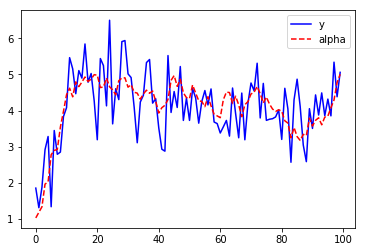

In [10]:
n=100
np.random.seed(0)
su=.05
se=.5
e=np.random.normal(0, np.sqrt(se), n)
u=np.random.normal(0, np.sqrt(su), n)
z=1
wreal=.86
const=.6
y=np.zeros(n)
alpha=np.zeros(n)
y[0]=const+e[0]
alpha[0]=const+u[0]
for t in range(1,n):
  y[t]=z*alpha[t-1]+e[t]
  alpha[t]=const+wreal*alpha[t-1]+u[t]
plt.plot(y,'b',label="y")
plt.plot(alpha,'r--',label="alpha")
plt.legend()
plt.show()  

然后定义一个极大似然函数：

In [11]:
a=np.zeros(n)
p=np.zeros(n)
p[0]=10
k=np.zeros(n)
v=np.zeros(n)
def ML(mypa):
    w=abs(mypa[0])
    se=abs(mypa[1])
    su=abs(mypa[2])
    co=abs(mypa[3])
    z=1
    likelihood=0
    for t in range(1,n):
        k[t]=(z*w*p[t-1])/(z**2*p[t-1]+se)
        p[t]=w**2*p[t-1]-w*z*k[t]*p[t-1]+su
        v[t]=y[t]-z*a[t-1]
        a[t]=co+w*a[t-1]+k[t]*v[t]
        likelihood=likelihood+.5*np.log(2*np.pi)+.5*np.log(z**2*p[t-1]+se)+.5*(v[t]**2/(z**2*p[t-1]+se))
    return likelihood

作图查看估计得到的序列

In [14]:
res=optimize.minimize(ML,[0.85,0.5,0.1,0.3])
print("极大似然估计所得结果：",res.x)
trueparam=[wreal,se,su,const]
print("真实参数：",trueparam)

极大似然估计所得结果： [ 0.79359345 -0.45043077  0.06954959  0.88488742]
真实参数： [0.86, 0.5, 0.05, 0.6]


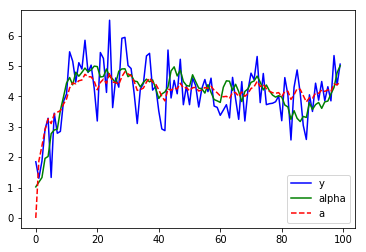

In [15]:
ML(res.x)
plt.plot(y,'b',label='y')
plt.plot(alpha,'g',label='alpha')
plt.plot(a,'r--',label='a')
plt.legend()
plt.show()

如上所述使用对数似然的一个潜在问题与参数的数量有关。对于极大似然估计而言，参数越少，估计越有效。因此下面使用concatenate形式的极大似然函数。

In [118]:
n=100
np.random.seed(0)
su=.1
se=.4
qreal=su/se
e=np.random.normal(0, np.sqrt(se), n)
u=np.random.normal(0, np.sqrt(su), n)
# e=np.sqrt(se)*np.random.randn(n)
# u=np.sqrt(su)*np.random.randn(n)
z=1
wreal=.97
y=np.zeros(n)
alpha=np.zeros(n)
y[0]=e[0]
alpha[0]=u[0]
for t in range(1,n):
  y[t]=z*alpha[t-1]+e[t]
  alpha[t]=wreal*alpha[t-1]+u[t]
########### standard Kalman filter approach###################
a=np.zeros(n)
p=np.zeros(n)
p[0]=10
k=np.zeros(n)
v=np.zeros(n)
def conML(mypa):
    w=abs(mypa[0])
    q=abs(mypa[1])
    z=1
    likelihood=0
    sigmae=0
    for t in range(1,n):
        k[t]=(z*w*p[t-1])/(z**2*p[t-1]+1)
        p[t]=w**2*p[t-1]-w*z*k[t]*p[t-1]+q
        v[t]=y[t]-z*a[t-1]
        a[t]=w*a[t-1]+k[t]*v[t]
        sigmae=sigmae+(v[t]**2/(z**2*p[t-1]+1))
        likelihood=likelihood+.5*np.log(2*np.pi)+.5+.5*np.log(z**2*p[t-1]+1)
    likelihood+=.5*n*np.log(sigmae/n) 
    return likelihood

In [127]:
res=optimize.minimize(conML,[0.85,0.5])
print("极大似然估计所得结果：",res.x)
trueparam=[wreal,su/se]
print("真实参数：",trueparam)

极大似然估计所得结果： [ 0.97624782  0.28574339]
真实参数： [0.97, 0.25]


作图查看改进的极大似然函数的估计效果，从直观上即可看出比之前的拟合程度更高，且参数更为准确。

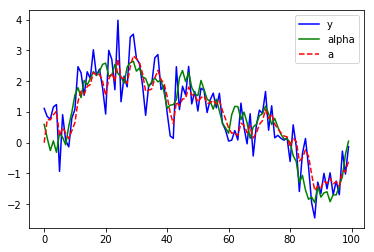

In [121]:
conML(res.x)
plt.plot(y,'b',label='y')
plt.plot(alpha,'g',label='alpha')
plt.plot(a,'r--',label='a')
plt.legend()
plt.show()

下面将卡尔曼滤波和极大似然估计结合起来。

生成如下序列：

$$\begin{array}{c}y_t=\alpha_{t-1}+e_t\\\alpha_{t}=.2+.85 \alpha_{t-1}+u_t \end{array}$$ 

其中$e \sim N(\mu_e=0;\sigma_{e}^2=.1)$ ， $u \sim N(\mu_u=0;\sigma_{u}^2=.05)$

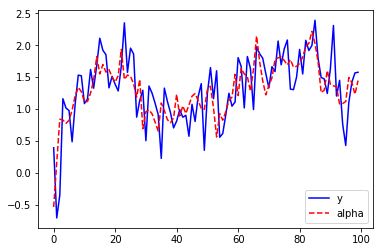

In [131]:
n=100
np.random.seed(1265)
su=.05
se=.1
const=.2
wreal=0.85
e=np.sqrt(se)*np.random.randn(n)
u=np.sqrt(su)*np.random.randn(n)
y=np.zeros(n)
alpha=np.zeros(n)
y[0]=e[0]
alpha[0]=u[0]
for t in range(1,n):
  y[t]=alpha[t-1]+e[t]
  alpha[t]=const+wreal*alpha[t-1]+u[t]
plt.plot(y,'b',label="y")
plt.plot(alpha,'r--',label="alpha")
plt.legend()
plt.show()  

如果使用标准的卡尔曼滤波可以得到如下结果：

In [139]:
a=np.zeros(n)
p=np.zeros(n)
p[0]=1
k=np.zeros(n)
v=np.zeros(n)
def conML(mypa):
    w=abs(mypa[0])
    q=abs(mypa[1])
    co=abs(mypa[2])
    z=1
    likelihood=0
    sigmae=0
    for t in range(1,n):
        k[t]=(z*w*p[t-1])/(z**2*p[t-1]+1)
        p[t]=w**2*p[t-1]-w*z*k[t]*p[t-1]+q
        v[t]=y[t]-z*a[t-1]
        a[t]=w*a[t-1]+k[t]*v[t]
        sigmae=sigmae+(v[t]**2/(z**2*p[t-1]+1))
        likelihood=likelihood+.5*np.log(2*np.pi)+.5+.5*np.log(z**2*p[t-1]+1)
    likelihood+=.5*n*np.log(sigmae/n) 
    return likelihood

In [148]:
res=optimize.minimize(conML,[.9,1,.1])
w=res.x[0]
q=res.x[1]
co=res.x[2]
likelihood=0
sigmae=0
# 利用估计得到的参数进行卡尔曼滤波
for t in range(1,n):
    k[t]=(z*w*p[t-1])/(z**2*p[t-1]+1)
    p[t]=w**2*p[t-1]-w*z*k[t]*p[t-1]+q
    v[t]=y[t]-z*a[t-1]
    a[t]=w*a[t-1]+k[t]*v[t]
    sigmae=sigmae+(v[t]**2/(z**2*p[t-1]+1))
    likelihood=likelihood+.5*np.log(2*np.pi)+.5+.5*np.log(z**2*p[t-1]+1)
likelihood+=.5*n*np.log(sigmae/n) 
sigmae=sigmae/len(y)
sigmau=q*sigmae
print("极大似然估计所得结果：",res.x)
trueparam=[wreal,su/se,const]
print("真实参数：",trueparam)

极大似然估计所得结果： [ 0.99575977  0.34819689  0.1       ]
真实参数： [0.85, 0.5, 0.2]
